# Optosynth

... is it _really_ synthetic?! :-)

In [1]:
%matplotlib inline

import os
import sys
notebook_path = os.path.abspath('')
sources_path = os.path.abspath(os.path.join(notebook_path, 'sources'))
sys.path.insert(0, sources_path)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from pprint import pprint

from specs import *
from optosynth import Optosynth

device = torch.device("cpu")
dtype = torch.float32

## Paths

In [2]:
optosynth_data_path = '/home/jupyter/mb-ml-data-disk/Optosynth'
output_path = '/home/jupyter/mb-ml-data-disk/Optosynth_output'
output_prefix = 'test_data_5'

if not os.path.exists(output_path):
    os.mkdir(output_path)

## (Optional) Download pre-processed Allen Brain data

In [3]:
# if not os.path.exists(optosynth_data_path):
#     os.mkdir(optosynth_data_path)
# assert os.path.exists(optosynth_data_path)
# data_bucket = 'gs://mb_optosynth_data'

In [4]:
# %%bash -s "$data_bucket" "$optosynth_data_path"
# mkdir -p $2
# gsutil -m cp -r $1/* $2

## Load summary of available sweeps

In [5]:
# summary of sweeps
ephys_summary_df = pd.read_csv(
    os.path.join(optosynth_data_path, 'processed_electrophysiology_summary.csv'), index_col=0)
ephys_summary_df.head(5)

,cell_id,sweep_index,stim_amp,n_spikes
0,480116737,0,-110.000000,0
1,480116737,1,-70.000000,0
2,480116737,2,-50.000000,0
3,480116737,3,-30.000002,0
4,480116737,4,10.000000,0


## Optosynth Specs

In [28]:
opto_specs = OptosynthSpecs(
    width=512,
    height=180,
    sampling_rate=500,
    duration_per_segment=2.00,
    scale_factor=1.00,  # 1.0
    n_neurons=50,  # 50
    min_neuron_fluorescence_scale_factor=0.1,
    max_neuron_fluorescence_scale_factor=1.0,
    stim_amp_range_list=[
        (25, 50),
        (50, 75),
        (75, 100),
        (100, 125),
        (125, 150),
        (150, 175),
        (175, 200)])

neuron_specs = SyntheticNeuronSpecs(
    dendritic_backprop_velocity=1e4,  # 5e4
    dendritic_backprop_decay_lengthscale=20,  # 50
    min_reporter_density=1,
    max_reporter_density=10,
    reporter_density_var_lengthscale=2,
    ephys_lowpass_freq=250)

bg_specs = BackgroundFluorescenceSpecs(
    dynamic_n_components=20,
    dynamic_x_lengthscale=10,
    dynamic_y_lengthscale=100,
    dynamic_fluorophore_density_scale=0.5,
    dynamic_temporal_frequency=100,
    static_x_lengthscale=5,
    static_y_lengthscale=5,
    static_min_total_fluorophore_density=0.0,
    static_max_total_fluorophore_density=0.1)    

v2f_specs = VoltageToFluorescenceSpecs(
    beta=0.01,
    v1=-100,
    f1=0.4,
    v2=50,
    f2=1.0)

cam_specs = CameraSpecs(
    dc_offset=500,
    gaussian_noise_std=10.,
    psf_lengthscale=0.25,  # 1.0
    readout_per_photon=2.2,
    photon_per_fluorophore=50.)

## Generate

In [29]:
synth = Optosynth(
    opto_specs=opto_specs,
    neuron_specs=neuron_specs,
    bg_specs=bg_specs,
    v2f_specs=v2f_specs,
    cam_specs=cam_specs,
    ephys_summary_df=ephys_summary_df,
    optosynth_data_path=optosynth_data_path,
    device=device,
    dtype=dtype)

Randomly choosing 50 from 446 usable neurons ...
Loading morphology and electrophysiology data ...


  0%|          | 0/50 [00:00<?, ?it/s]

Instantiating the background pattern generator ...
Instantiating the camera ...
Generating ground truth masks ...


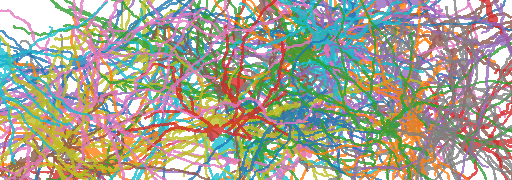

In [31]:
synth.get_combined_mask()

In [32]:
# go!
synth.generate_fluorescence_data()
synth.generate_camera_data()

Generating synthetic data for segment 1 / 1 ...


  0%|          | 0/1000 [00:00<?, ?it/s]

Generating clean and noisy camera readout for segment 1 / 1 ...


  0%|          | 0/1000 [00:00<?, ?it/s]

## Save

In [33]:
synth.save(os.path.join(output_path, output_prefix))

## Explore

In [34]:
for _, _, file in os.walk(os.path.join(output_path, output_prefix)):
    pprint(file)

['noisy_movie_tyx.npy',
 'neuron_mean_fluorescence_nt.npy',
 'background_tyx.npy',
 'soma_coords_n2.npy',
 'clean_movie_tyx.npy',
 'clean_fluorescence_tyx.npy',
 'masks_nyx.npy']


In [35]:
masks_nyx = np.load(os.path.join(output_path, output_prefix, 'masks_nyx.npy'))

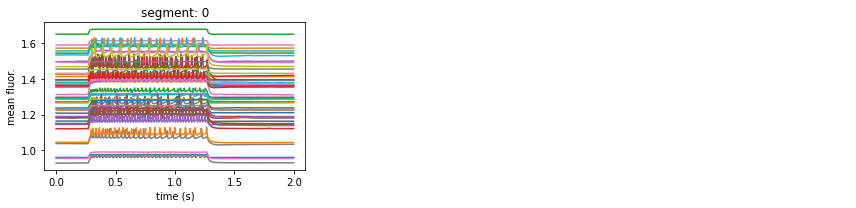

In [36]:
n_segments_per_row = 3
nrows = synth.n_segments // n_segments_per_row + 1
ncols = n_segments_per_row
fig, axs = plt.subplots(nrows, ncols, figsize=(n_segments_per_row * 4, 3 * nrows))
axs = np.asarray(axs).flatten()
for i_segment in range(synth.n_segments):
    ax = axs[i_segment]
    for i_neuron in range(opto_specs.n_neurons):
        ax.plot(
            synth.time_per_segment,
            synth.neuron_mean_fluorescence_nt_list[i_segment][i_neuron, :])
        ax.set_xlabel('time (s)')
        ax.set_ylabel('mean fluor.')
        ax.set_title(f'segment: {i_segment}')
for i_ax in range(synth.n_segments, nrows * ncols):
    ax = axs[i_ax]
    ax.axis('off')
fig.tight_layout()

In [37]:
# dynamic background components
fig, axs = plt.subplots(nrows=bg_specs.dynamic_n_components, figsize=(5, 2 * bg_specs.dynamic_n_components))
axs = np.asarray(axs)
for i_bg in range(bg_specs.dynamic_n_components):
    axs[i_bg].imshow(synth.bg_gen.dynamic_bg_nyx[i_bg, ...], origin='lower', cmap=plt.cm.Greys_r)

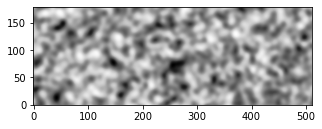

In [38]:
# static background
fig = plt.figure(figsize=(5, 2))
ax = plt.gca()
ax.imshow(synth.bg_gen.static_bg_yx, origin='lower', cmap=plt.cm.Greys_r)

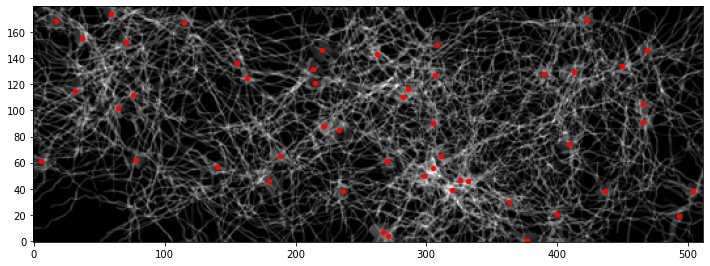

In [39]:
# clean movie (first frame of the first segment)
fig = plt.figure(figsize=(12, 5))
plt.imshow(
    synth.clean_movie_tyx_list[0][0, ...],
    cmap=plt.cm.Greys_r,
    origin='lower')
plt.scatter(synth.xs_n, synth.ys_n, color='red', s=20)

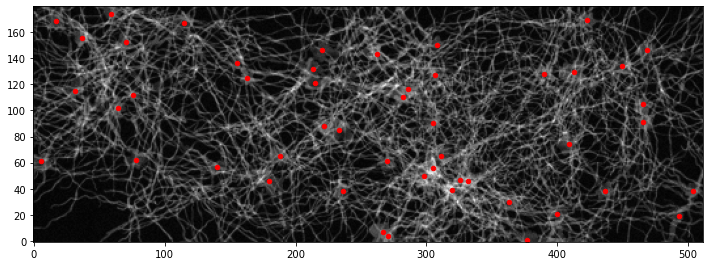

In [40]:
# noisy movie (first frame of the first segment)
fig = plt.figure(figsize=(12, 5))
plt.imshow(
    synth.noisy_movie_tyx_list[0][0, ...],
    cmap=plt.cm.Greys_r,
    origin='lower')
plt.scatter(synth.xs_n, synth.ys_n, color='red', s=20)

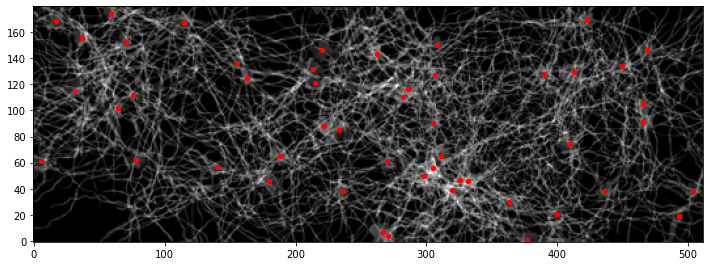

In [41]:
# total neuron fluorescence (first frame of the first segment)
fig = plt.figure(figsize=(12, 5))
plt.imshow(
    synth.neuron_fluorescence_tyx_list[0][0, ...],
    cmap=plt.cm.Greys_r,
    origin='lower')
plt.scatter(synth.xs_n, synth.ys_n, color='red', s=20)

In [42]:
import PIL

In [43]:
PIL.__version__

'8.1.0'

In [44]:
np.__version__

'1.18.5'

In [45]:
from typing import List, Set, Union, Dict, Tuple, Any, Optional

import matplotlib.pylab as plt
from skimage import io
from matplotlib import animation
from IPython.display import HTML


def show_video(
        video: np.ndarray,
        figsize: Tuple[int, int] = (8, 4),
        interval: int = 50,
        vmin: float = 0.,
        vmax: float = 1.):
    """
    :param video: an ndarray with shape (n_frames, height, width)
    """
    
    fig = plt.figure(figsize=figsize)
    ax = plt.gca()

    # image
    ax.axis('off')
    im = ax.imshow(video[0, ...], cmap=plt.cm.gray, aspect='equal', vmin=vmin, vmax=vmax)
    
    plt.tight_layout()
    plt.close()

    def init():
        im.set_data(video[0, ...])

    def animate(i):
        im.set_data(video[i, ...])

    anim = animation.FuncAnimation(
        fig, animate, init_func=init, frames=video.shape[0],
        interval=interval)
    
    return HTML(anim.to_html5_video())